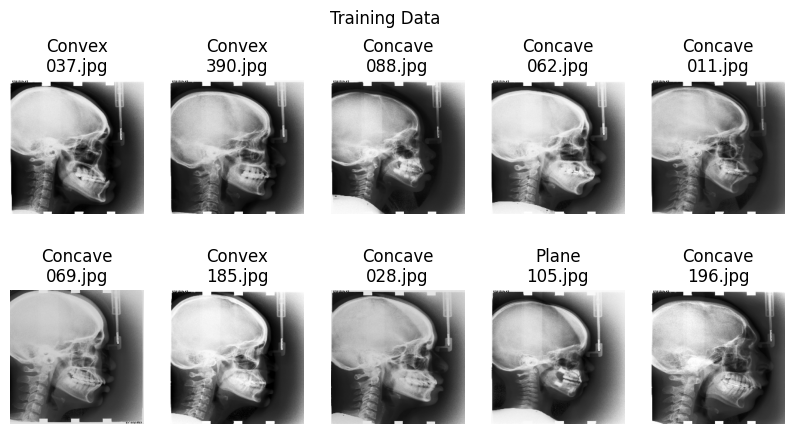

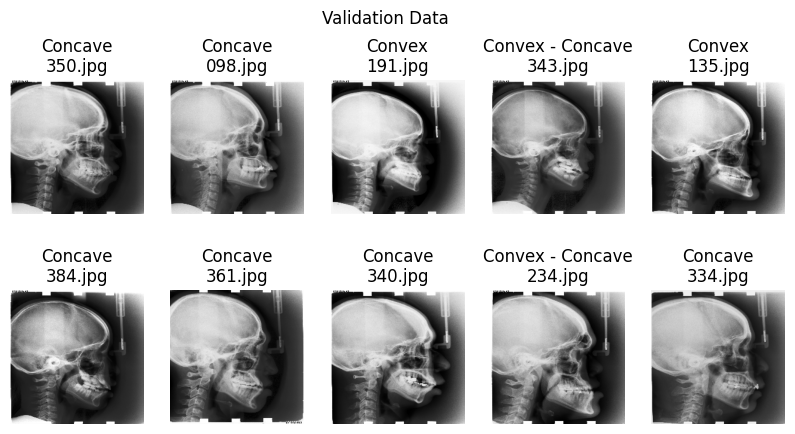

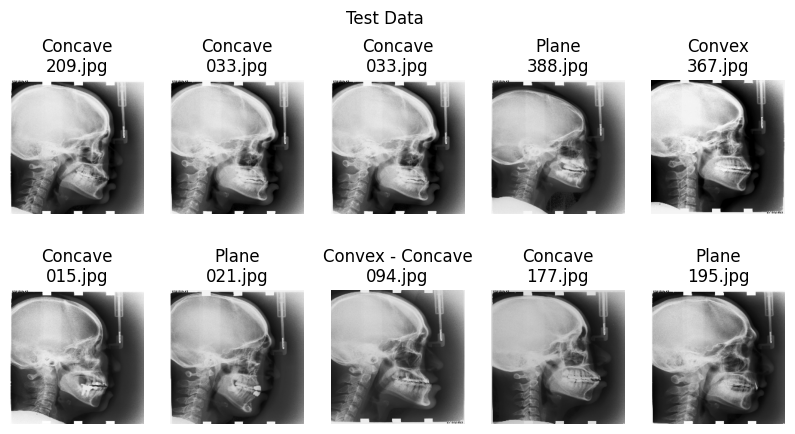

In [4]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, f1_score
import random

# Paths to CSV file and images folder
csv_file = '/content/drive/MyDrive/Soft_Tissue-20250116T155622Z-001/Soft_Tissue/Final - Facial Profile Types.csv'
image_folder = '/content/drive/MyDrive/Soft_Tissue-20250116T155622Z-001/Soft_Tissue/cepha400'

# Load CSV
df = pd.read_csv(csv_file)

# Remove "Concave - Convex" class
df = df[df['type'] != 'Concave - Convex']

# Function to get zero-padded image filenames
def get_image_path(image_id, folder):
    image_filename = f"{str(image_id).zfill(3)}.jpg"
    return os.path.join(folder, image_filename), image_filename  # Return path and filename

# Prepare dataset: (Image, Tabular Features, Label, Image Name)
combined_data = []
for index, row in df.iterrows():
    image_id = row['data']
    label = row['type']
    upper_lip = row['upper_lip']
    lower_lip = row['lower_lip']

    image_path, image_filename = get_image_path(image_id, image_folder)
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        combined_data.append((img_array, [upper_lip, lower_lip], label, image_filename))
    except FileNotFoundError:
        print(f"Image {image_path} not found.")
        continue
import tensorflow.keras.backend as K



# Convert tabular features to One-Hot Encoding
tabular_features = np.array([sample[1] for sample in combined_data])
encoder = OneHotEncoder(sparse_output=False)
tabular_features_encoded = encoder.fit_transform(tabular_features)

# Encode the labels
labels = [sample[2] for sample in combined_data]
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

# Extract images and image names
images = np.array([sample[0] for sample in combined_data])
image_filenames = np.array([sample[3] for sample in combined_data])

# Create tuples with all mapped features
data_tuples = list(zip(images, tabular_features_encoded, labels_one_hot, image_filenames))

# Split dataset into Train (70%), Validation (15%), Test (15%)
train_data, temp_data = train_test_split(data_tuples, test_size=0.3, stratify=labels_encoded, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[np.argmax(sample[2]) for sample in temp_data], random_state=42)

# Visualization of images and labels after splitting
def visualize_data(data, title):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        idx = random.randint(0, len(data) - 1)
        img, _, label, img_name = data[idx]
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{label_encoder.inverse_transform([np.argmax(label)])[0]}\n{img_name}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

visualize_data(train_data, "Training Data")
visualize_data(val_data, "Validation Data")
visualize_data(test_data, "Test Data")

# Unpack Train, Validation, Test sets correctly
X_train_img = np.array([sample[0] for sample in train_data])
X_train_tabular = np.array([sample[1] for sample in train_data])
y_train = np.array([sample[2] for sample in train_data])

X_val_img = np.array([sample[0] for sample in val_data])
X_val_tabular = np.array([sample[1] for sample in val_data])
y_val = np.array([sample[2] for sample in val_data])

X_test_img = np.array([sample[0] for sample in test_data])
X_test_tabular = np.array([sample[1] for sample in test_data])
y_test = np.array([sample[2] for sample in test_data])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

augmented_images, augmented_tabular, augmented_labels = [], [], []

for i in range(len(X_train_img)):
    img = X_train_img[i].reshape((1,) + X_train_img[i].shape)
    tabular_features = X_train_tabular[i]
    label = y_train[i]

    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(5):
        aug_img = next(aug_iter)[0]
        augmented_images.append(aug_img)
        augmented_tabular.append(tabular_features)
        augmented_labels.append(label)

X_train_img = np.vstack([X_train_img, np.array(augmented_images)])
y_train = np.vstack([y_train, np.array(augmented_labels)])
X_train_tabular = np.vstack([X_train_tabular, np.array(augmented_tabular)])





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU is available:", gpus)
    print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())
else:
    print("No GPU found. Running on CPU.")


GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU: True


In [9]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import BatchNormalization
import cv2
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the ResNet101 model (excluding top layers)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

# Identify the last convolutional layer dynamically
last_conv_layer_name = [layer.name for layer in base_model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

# Image feature extraction
image_input = Input(shape=(224, 224, 3))
x = base_model(image_input, training=False)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

# Tabular feature input
tabular_input = Input(shape=(X_train_tabular.shape[1],))
yt = Dense(64, activation='relu')(tabular_input)
yt = Dense(32, activation='relu')(yt)
yt = BatchNormalization()(yt)

# Concatenate image and tabular features
combined = Concatenate()([x, yt])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(y_train.shape[1], activation='softmax')(z)

# Define model
model = Model(inputs=[image_input, tabular_input], outputs=z)

# Compile model with Categorical Focal Loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=CategoricalFocalCrossentropy(),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    [X_train_img, X_train_tabular], y_train,
    validation_data=([X_val_img, X_val_tabular], y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Print validation accuracy and loss
print("Validation Accuracy:", max(history.history['val_accuracy']))
print("Validation Loss:", min(history.history['val_loss']))

# Evaluate on test set
y_pred = model.predict([X_test_img, X_test_tabular])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print performance metrics
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
print(f"Test Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.4f}")
print(f"Test F1 Score: {f1_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")




Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 473ms/step - accuracy: 0.2751 - loss: 0.4048 - val_accuracy: 0.1667 - val_loss: 0.1783
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.4161 - loss: 0.2552 - val_accuracy: 0.6667 - val_loss: 0.1470
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.5775 - loss: 0.1676 - val_accuracy: 0.6000 - val_loss: 0.1271
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.6693 - loss: 0.1184 - val_accuracy: 0.7667 - val_loss: 0.0865
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.7769 - loss: 0.0830 - val_accuracy: 0.7667 - val_loss: 0.0750
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.7988 - loss: 0.0688 - val_accuracy: 0.9333 - val_loss: 0.0537
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.8724 - loss: 0.0505 - val_accuracy: 0.9333 - val_loss: 0.0309
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8834 - loss: 0.0397 - val_accura

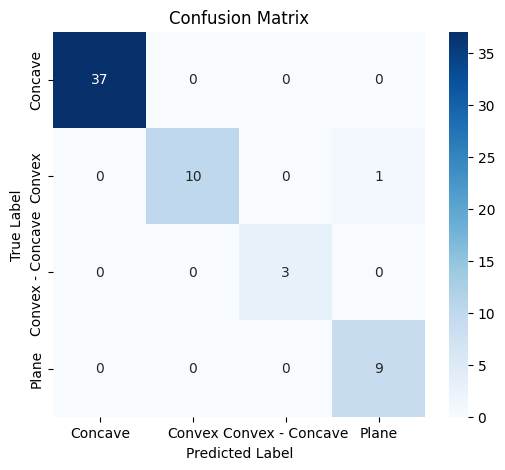

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have y_true_classes and y_pred_classes already defined as the true and predicted labels

# Compute Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix using seaborn heatmap
plt.figure(figsize=(6, 5))  # You can adjust the figure size based on preference
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



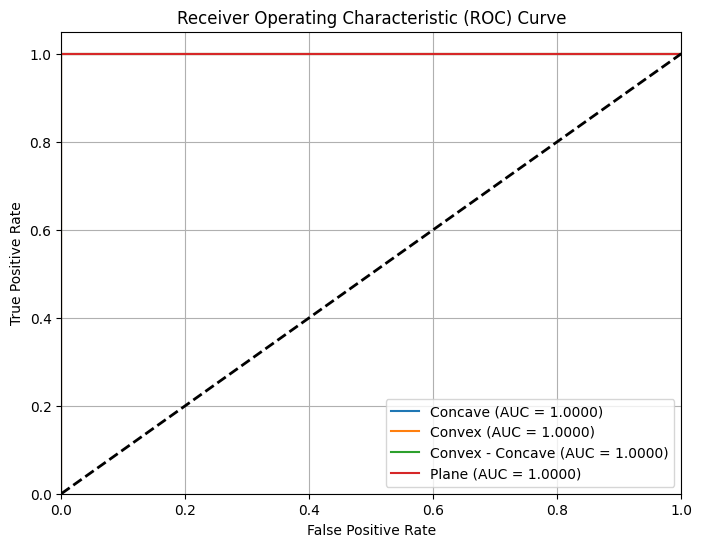

In [13]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [20]:
# Print the layers of the model to identify the last convolutional layer
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name)


conv1_conv
conv2_block1_1_conv
conv2_block1_2_conv
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block2_1_conv
conv2_block2_2_conv
conv2_block2_3_conv
conv2_block3_1_conv
conv2_block3_2_conv
conv2_block3_3_conv
conv3_block1_1_conv
conv3_block1_2_conv
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block2_1_conv
conv3_block2_2_conv
conv3_block2_3_conv
conv3_block3_1_conv
conv3_block3_2_conv
conv3_block3_3_conv
conv3_block4_1_conv
conv3_block4_2_conv
conv3_block4_3_conv
conv4_block1_1_conv
conv4_block1_2_conv
conv4_block1_0_conv
conv4_block1_3_conv
conv4_block2_1_conv
conv4_block2_2_conv
conv4_block2_3_conv
conv4_block3_1_conv
conv4_block3_2_conv
conv4_block3_3_conv
conv4_block4_1_conv
conv4_block4_2_conv
conv4_block4_3_conv
conv4_block5_1_conv
conv4_block5_2_conv
conv4_block5_3_conv
conv4_block6_1_conv
conv4_block6_2_conv
conv4_block6_3_conv
conv4_block7_1_conv
conv4_block7_2_conv
conv4_block7_3_conv
conv4_block8_1_conv
conv4_block8_2_conv
conv4_block8_3_conv
conv4_block9_1_conv
conv4_blo

In [30]:
# Dynamically find the last convolutional layer
last_conv_layer_name = None
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        print(f"Found Conv2D Layer: {last_conv_layer_name}")
        break

if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in the model.")


Found Conv2D Layer: conv1_conv


In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def generate_gradcam_heatmap(model, image, class_idx, last_conv_layer_name):
    """
    Generates a Grad-CAM heatmap for a given image and model.
    """
    # Create a model that outputs the feature map of the last convolutional layer and the model's predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    heatmap_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    # Get the gradient of the class with respect to the feature map
    with tf.GradientTape() as tape:
        conv_output, predictions = heatmap_model(image)
        loss = predictions[:, class_idx]  # Focus on the target class

    # Compute the gradient of the class with respect to the feature map
    grads = tape.gradient(loss, conv_output)

    # Pool the gradients across all axes (spatial dimensions)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Get the feature map of the last convolutional layer
    conv_output = conv_output[0]

    # Multiply each channel in the feature map by the corresponding gradient value
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Compute the heatmap by averaging the feature map across channels
    heatmap = np.mean(conv_output, axis=-1)

    # Normalize the heatmap to [0, 1]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap
